# ⬇️ Install Dependencies

In [ ]:
!pip install transformers torch torchvision wandb datasets pandas accelerate peft
!python -m spacy download en_core_web_sm

In [ ]:
import torch; assert torch.cuda.get_device_capability()[0] >= 8, 'Hardware not supported for Flash Attention'
# install flash-attn
!pip install ninja packaging
!MAX_JOBS=2 pip install flash-attn --no-build-isolation

# ⚖️ Weights & Biases

In [ ]:
import wandb

wandb.login()

In [ ]:
import os 

wandb_project = "journal-finetune-dolphin-2.6"

run = wandb.init(
    # Set the project where this run will be logged
    project=wandb_project,
    # Track hyperparameters and run metadata
    config={
        "learning_rate": 0.01,
        "epochs": 10,
    },
)

if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

# 🧮 Data Preprocessing

In [26]:
import pandas as pd

df = pd.read_json("../data/processed/journal_entries.jsonl", lines=True)

In [11]:
# Check for missing values in both date and note columns
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Validate Date Format - if the dates are already in Timestamp format, they are valid
invalid_dates = df[~df['date'].apply(lambda x: isinstance(x, pd.Timestamp))]
print("\nInvalid dates found:\n", invalid_dates)

# Check Journal Entry Format
# Ensure that all journal entries are strings
non_string_entries = df[~df['note'].apply(lambda x: isinstance(x, str))]
print("\nNon-string entries found:\n", non_string_entries)

# Data Consistency and Completeness
# Look for any anomalies in data, such as extremely short or long entries, or entries with unusual characters
print("\nStatistics for 'note' lengths:\n", df['note'].str.len().describe())

Missing values in each column:
 date    0
note    0
dtype: int64

Invalid dates found:
 Empty DataFrame
Columns: [date, note]
Index: []

Non-string entries found:
 Empty DataFrame
Columns: [date, note]
Index: []

Statistics for 'note' lengths:
 count      702.000000
mean      2221.309117
std       3101.092724
min          0.000000
25%        309.500000
50%       1191.500000
75%       3118.500000
max      42126.000000
Name: note, dtype: float64


In [32]:
import re

def clean_text(text):
    # Removing headers/footers not part of the story
    text = re.sub(r"\s*Page\s*\|\s*\d+\s*\|\s*American\s*Literature\s*", "", text)

    # Standardizing punctuation and whitespace
    # Replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text)

    # Standardize quotation marks
    text = text.replace("“", '"').replace("”", '"')

    # Standardize apostrophes
    text = text.replace("’", "'").replace("‘", "'")

    # lowercase
    text = text.lower()

    # Remove leading/trailing whitespace
    return text.strip()

# Clean the text
df['note_cleaned'] = df['note'].apply(clean_text)

# 📏 Tokenize Data & Explore Token Lengths

In [2]:
from transformers import AutoTokenizer

model_id = "cognitivecomputations/dolphin-2.6-mistral-7b-dpo-laser"

tokenizer = AutoTokenizer.from_pretrained(model_id)

In [3]:
# function that encodes text input with tokenizer and returns the length of the tokenized input
def count_tokens(text):
    return len(tokenizer.encode(text))

count = tokenizer.encode("Hello, my dog is cute.")
count

[1, 22557, 28725, 586, 3914, 349, 17949, 28723]

In [27]:
# Apply the function to the 'note' column
df['token_length'] = df['note'].apply(count_tokens)

In [11]:
df['token_length'].describe()

count      702.000000
mean       554.128205
std        765.610486
min          1.000000
25%         79.000000
50%        303.000000
75%        760.750000
max      10586.000000
Name: token_length, dtype: float64

In [77]:
# Mean is 554 and 512 is a nice standard token count in the same range
max_sequence_length = 512

In [16]:
# get the number of entries that exceed the maximum sequence length
exceeding_max_length = df[df['token_length'] > max_sequence_length]
print("Number of entries exceeding the maximum length:", len(exceeding_max_length))

Number of entries exceeding the maximum length: 251


In [28]:
# Remove entries with empty notes
df = df[df['note'].apply(lambda x: len(x) > 0)]
print("Empty entries: ", len(df[df['note'].apply(lambda x: len(x) < 0)]))

Empty entries:  0


In [29]:
# Remove very short entries with no value
entries_ix_to_delete = [40, 47, 65, 90, 103, 110, 117, 130, 132, 153, 156, 165, 171, 174, 205, 219, 247, 291, 292, 315, 318, 336, 342, 356, 385, 407, 424, 433, 451, 474, 530, 534, 541, 567, 578, 589, 602, 619, 620, 668, 690, 697]

df = df.drop(entries_ix_to_delete)

# Reset the index if you want a continuous index after deletion
df.reset_index(drop=True, inplace=True)

# ✂️ Segment Long Entries

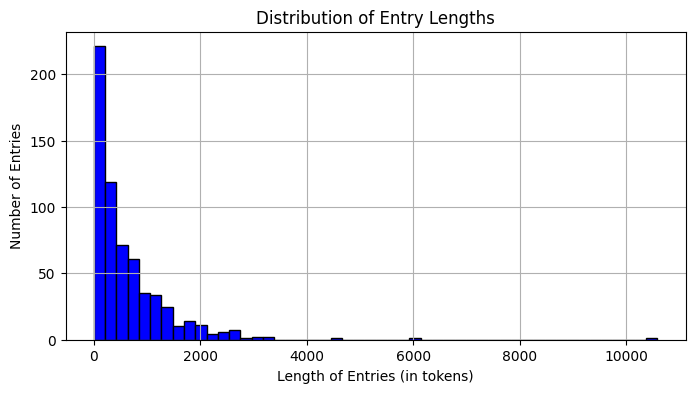

In [31]:
# Plot the distribution of token lengths
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(8, 4))
plt.hist(df['token_length'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Entry Lengths')
plt.xlabel('Length of Entries (in tokens)')
plt.ylabel('Number of Entries')
plt.grid(True)
plt.show()

In [137]:
def format_journal_entry(date, note=""):
    """
    Formats a journal entry with a given date and note content for AI training.

    Parameters:
    - date (str): The date of the journal entry in 'YYYY-MM-DD' format.
    - note (str): The content of the journal entry.

    Returns:
    - str: A formatted string suitable for AI model training, incorporating the
           date, a personalized prompt with the name "Trey", and the journal note.
    """
    # Construct the training prompt with the date, personalized identifier, and the note
    formatted_entry = f"Date: {date}\nInsight by Treysifer:\n{note}"
    
    return formatted_entry

# Example usage
example_date = "2024-01-31"
example_note = "Reflecting on the importance of daily mindfulness practices."
formatted_entry = format_journal_entry(example_date, example_note)

print(formatted_entry, "\n")
print(format_journal_entry(example_date))

Date: 2024-01-31
Insight by Treysifer:
Reflecting on the importance of daily mindfulness practices. 

Date: 2024-01-31
Insight by Treysifer:



In [138]:
import spacy
from typing import List
import pandas as pd


nlp = spacy.load("en_core_web_sm")


def get_text_segments_and_format(
    row: pd.Series,
    max_token_limit=max_sequence_length,
) -> List[str]:
    date = row["date_cleaned"]
    note = row["note_cleaned"]

    # Initialize the NLP model for sentence tokenization
    doc = nlp(note)
    sentences = [sent.text.strip() for sent in doc.sents]
    segments: List[str] = []
    training_prompt_header_tokens = count_tokens(format_journal_entry(date))

    curr_segment = ""
    # initialize the curr_segment token size with the training prompt token size
    sequence_token_size = training_prompt_header_tokens

    for sentence in sentences:
        sentence += " "
        current_sentence_token_size = count_tokens(sentence)

        if sequence_token_size + current_sentence_token_size <= max_token_limit:
            # Append sentence to the curr_segment until token size of curr_segment >= max_token_limit
            curr_segment += sentence
            sequence_token_size += current_sentence_token_size
        else:
            formatted_segment = format_journal_entry(date, curr_segment)
            segments.append(formatted_segment)
            # The next segment begins with the curr sentence that has no home
            curr_segment = sentence
            sequence_token_size = training_prompt_header_tokens + count_tokens(sentence)

    # Append the last segment if it's not empty, including the training prompt
    if curr_segment:
        formatted_segment = format_journal_entry(date, curr_segment)
        segments.append(formatted_segment)

    return segments

In [62]:
import textwrap


def test_segmenting_and_formatting(
    sample_size: int,
    max_token_limit=max_sequence_length,
):
    samples_df = df.sample(sample_size, random_state=42)

    for idx, row in samples_df.iterrows():
        segments = get_text_segments_and_format(row, max_token_limit=max_token_limit)

        for i, segment in enumerate(segments):
            print(f"🍊 Segment {i+1}: {count_tokens(segment)}\n")
            print(textwrap.fill(segment, width=70), "\n\n")
            if i == len(segments) - 1:
                print(
                    "----------------------------------------------------------------------"
                )

In [ ]:
# test_segmenting_and_formatting(1)

In [ ]:
def clean_date(datetime_obj):
    """
    Converts a datetime object to a date string without the time component.

    Parameters:
    - datetime_obj (datetime): The datetime object to be cleaned.

    Returns:
    - str: A string representing the date in 'YYYY-MM-DD' format.
    """
    # Format the datetime object to a date string (YYYY-MM-DD)
    return datetime_obj.strftime('%Y-%m-%d')

df["date_cleaned"] = df["date"].apply(clean_date)
df.head()

In [ ]:
df.sample(1, random_state=42)["note_cleaned"].values[0]

In [ ]:
df["segments"] = df.apply(get_text_segments_and_format, axis=1)
df.head()

# 🪡 Integrate Segments Into DataFrame

In [141]:
# sort entries by date
sorted_df = df.sort_values(by="date")
sorted_df.shape

(626, 6)

In [ ]:
sorted_df = sorted_df.reset_index().rename(columns={'index': 'entry_id'})
sorted_df.head()

# write text to the bottom of a csv file
def write_to_csv(file_path, text):
    with open(file_path, "a") as file:
        file.write(text)

In [143]:
# write sorted_df to a csv file
sorted_df.to_csv("../data/processed/journal_entries_segmented_sorted.csv", index=False)

In [144]:
relevant_columns = ["entry_id", "date_cleaned", "segments"]
flattened_segments = sorted_df[relevant_columns].explode('segments').reset_index().rename(columns={'segments': 'formatted_segment'})
flattened_segments = flattened_segments[["entry_id", "date_cleaned", "formatted_segment"]].rename(columns={"date_cleaned": "date"})

In [147]:
def print_segments(segments):
    for i, segment in enumerate(segments):
        print(f"🍊 Segment {i+1} ({count_tokens(segment)} tokens):")
        print(textwrap.fill(segment, width=70), "\n\n")
        if i == len(segments) - 1:
            print("----------------------------------------------------------------------")

In [148]:
print_segments(flattened_segments["formatted_segment"].values[:20])

🍊 Segment 1 (181 tokens):
Date: 2019-09-15 Insight by Treysifer: Over the next three weeks, I
will go on 12 onsite interviews at 12 amazing companies. I am excited
for these interviews and don't feel any pressure at all because I know
I am going to do well. I've prepared and prepared and then prepared
some more. At this point, all I have to do is show up, smile and enjoy
myself. The rest will come naturally. What it comes down to, just as
much as demonstrating your ability in the interview, is to walk
through the door and immediately be someone they want to work with.
And that person is someone who enjoys what they do. I'd like to say
something to these next three weeks of interviews: you better bring
it. Because I'm ready. 


🍊 Segment 2 (115 tokens):
Date: 2019-09-15 Insight by Treysifer: 1. Don't put all your eggs in
one basket 2. Antidepressants are awesome 3. I am capable of achieving
anything if I apply myself 4. I thrive on being single, but love is
nice too :) 5. The more you l

In [149]:
flattened_segments["date"].describe()

count           1291
unique           423
top       2022-06-28
freq              26
Name: date, dtype: object

In [ ]:
flattened_segments.head()

In [151]:
# write flattened_segments to a csv file
flattened_segments.to_csv("../data/processed/segments_flattened_formatted.csv", index=False)

# 🔀 Split data into train and test sets

Shuffling the data before splitting and then sorting the training and test sets chronologically. This approach aims to blend the benefits of random sampling with the preservation of chronological order within each set.

In [ ]:
# get 10 random samples from flattened_segments
eval_samples = flattened_segments.sample(10, random_state=42)

# write eval_samples to a csv file
eval_samples.to_csv("../data/processed/eval_samples.csv", index=False)

# remove eval_samples from flattened_segments
flattened_segments = flattened_segments.drop(eval_samples.index)

In [152]:
# Shuffle the DataFrame
segments_shuffled = flattened_segments.sample(frac=1).reset_index(drop=True)

# Split the data
split_index = int(len(segments_shuffled) * 0.8)
train_df = segments_shuffled[:split_index]
test_df = segments_shuffled[split_index:]

# Sort the training and test sets chronologically
train_df = train_df.sort_values(by='date', ascending=True)
test_df = test_df.sort_values(by='date', ascending=True)


In [153]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset, test_dataset

# write train_dataset and test_dataset to jsonl files
train_dataset.save_to_disk("../data/processed/train_dataset.jsonl")
test_dataset.save_to_disk("../data/processed/test_dataset.jsonl")

(Dataset({
     features: ['entry_id', 'date', 'formatted_segment', '__index_level_0__'],
     num_rows: 1032
 }),
 Dataset({
     features: ['entry_id', 'date', 'formatted_segment', '__index_level_0__'],
     num_rows: 259
 }))

# 🪙 Pre-Training Tokenization

In [154]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"
tokenizer.add_bos_token = True
tokenizer.add_eos_token = True


def tokenize_function(row):
    result = tokenizer(
        row["formatted_segment"],
        padding="max_length",
        truncation=True,
        max_length=max_sequence_length,
    )
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=False)
tokenized_val_dataset = test_dataset.map(tokenize_function, batched=False)

Map:   0%|          | 0/1032 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

1291


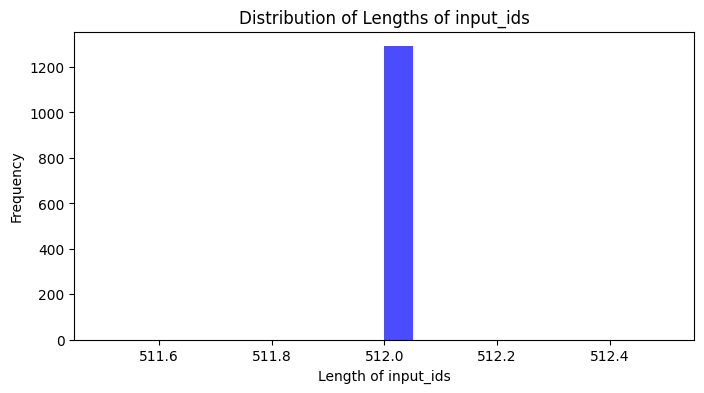

In [155]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(8, 4))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

# 📂 Load Base Model

In [ ]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

# Hugging Face model id
model_id = "cognitivecomputations/dolphin-2.6-mistral-7b-dpo-laser"

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

bnb_config.is_quantizable()

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    attn_implementation="flash_attention_2",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    trust_remote_code=True,
)

# 🏁 Evaluate Base Model & Establish Baseline

In [ ]:
from transformers import pipeline

# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

# pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

# 🔽 Configure Lora

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
print(model)

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

In [ ]:
print(model)

# 🏋🏽‍♂️ Train the Model

In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [ ]:
model = accelerator.prepare_model(model)

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
import transformers
from datetime import datetime

project = "journal-finetune"
base_model_name = "dolphin-2.6-mistral-7b-dpo-laser"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

args = transformers.TrainingArguments(
    output_dir=output_dir,
    warmup_steps=1,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    max_steps=1000,
    learning_rate=2.5e-5,  # Want a small lr for finetuning
    bf16=True,
    optim="paged_adamw_8bit",
    logging_steps=25,  # When to start reporting loss
    logging_dir="./logs",  # Directory for storing logs
    save_strategy="steps",  # Save the model checkpoint every logging step
    save_steps=25,  # Save checkpoints every 50 steps
    evaluation_strategy="steps",  # Evaluate the model every logging step
    eval_steps=25,  # Evaluate and save checkpoints every 50 steps
    do_eval=True,  # Perform evaluation at the end of training
    report_to="wandb",  # Comment this out if you don't want to use weights & baises
    run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}",  # Name of the W&B run (optional)
)

In [ ]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

# 🤞🏽 Try the Fine-Tuned Model

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-journal-finetune/checkpoint-300")

In [ ]:
def get_model_input(input_text):
    return eval_tokenizer(input_text, return_tensors="pt").to("cuda")


def get_model_output(model_input):
    output = eval_tokenizer.decode(
        model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0],
        skip_special_tokens=True,
    )
    return output


# Eval prompts
eval_prompts = [
    "Following the style of Edgar Allan Poe, generate a passage describing the interior of an ancient library filled with arcane books, where an unsettling secret lies hidden.",
    "Using Edgar Allan Poe's narrative style, write a story opening about a character who receives a cryptic letter leading them to an abandoned graveyard at midnight.",
    "Craft a poem that mirrors Edgar Allan Poe's thematic focus on the macabre and the supernatural, centering on a haunted seascape under the full moon.",
]

model_inputs = [get_model_input(prompt) for prompt in eval_prompts]

# Outputs from the base model
ft_model.eval()
with torch.no_grad():
    model_outputs = [get_model_output(input) for input in model_inputs]
    for i, output in enumerate(model_outputs):
        print(f"Prompt {i+1}: {eval_prompts[i]}\n\n")
        print("Output: \n")
        print(output, "\n\n")